In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [8]:
df = pd.read_csv('mid_cap_all_sectors_ret.csv')
df['date'] = pd.to_datetime(df['date'])

## **Only Log Return Feature**

**use low, medium, high vol threshold**

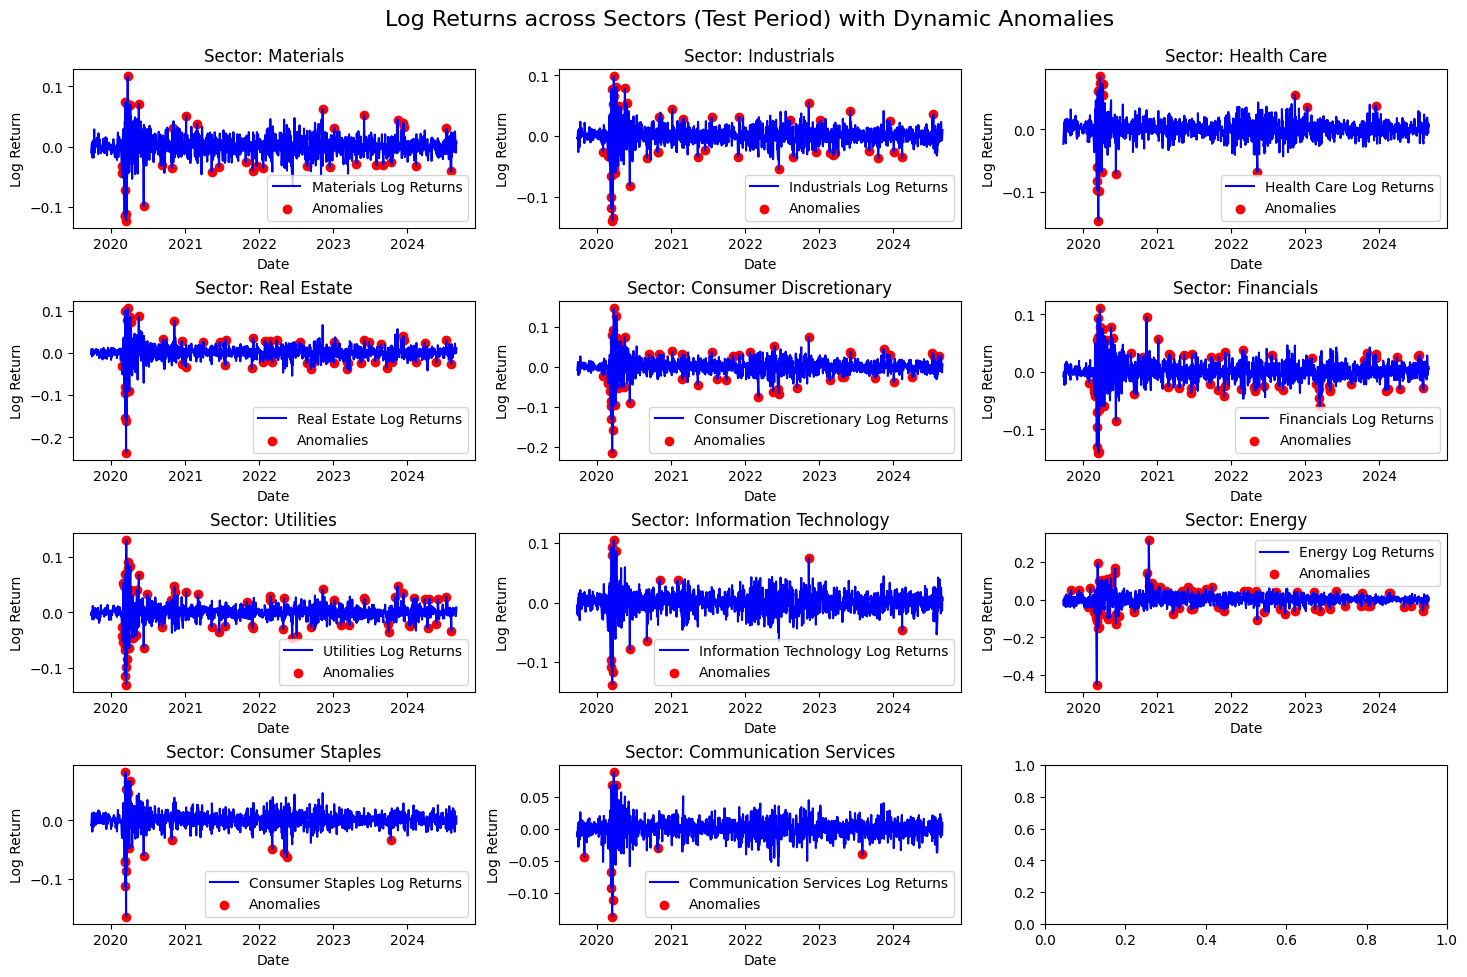

Anomaly Percentages by Sector in the Test Data:
                        Anomaly Percentage
Materials                         3.142627
Industrials                       3.787268
Health Care                       1.369863
Real Estate                       4.190169
Consumer Discretionary            4.754230
Financials                        6.043513
Utilities                         5.479452
Information Technology            1.128122
Energy                            6.688155
Consumer Staples                  1.369863
Communication Services            0.805802


In [9]:
sectors = df.columns[1:]

split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
best_params = {}
metrics = {}

param_grid = {
    'n_estimators': [85, 95, 100, 105, 115],
    'max_samples': [0.4, 0.5, 0.6, 0.7],
    'contamination': [0.03, 0.04, 0.045, 0.05, 0.055, 0.06]
}


# copy dynamic threshold
def compute_rolling_vol(data, window_size=20):
    return data.rolling(window=window_size).std()

def assign_vol_regimes(volatility, low_percentile=30, high_percentile=70):
    regimes = pd.DataFrame(index=volatility.index, columns=volatility.columns)
    thresholds = {}

    for feature in volatility.columns:
        vol_series = volatility[feature].dropna()
        low_thresh = np.percentile(vol_series, low_percentile)
        high_thresh = np.percentile(vol_series, high_percentile)
        thresholds[feature] = {'low': low_thresh, 'high': high_thresh}

        def regime_assignment(vol):
            if vol <= low_thresh:
                return 'low'
            elif vol <= high_thresh:
                return 'medium'
            else:
                return 'high'

        regimes[feature] = volatility[feature].apply(regime_assignment)

    return regimes, thresholds

# rolling vol
train_volatility = compute_rolling_vol(train_df[sectors])
train_volatility_regimes, thresholds = assign_vol_regimes(train_volatility)

# Step 2: Train Isolation Forest and calculate dynamic thresholds
train_scores = pd.DataFrame(index=train_df.index, columns=sectors)

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns across Sectors (Test Period) with Dynamic Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

for i, sector in enumerate(sectors):
    best_silhouette = -1
    best_config = None
    best_model = None
    for n_estimators in param_grid['n_estimators']:
        for max_samples in param_grid['max_samples']:
            for contamination in param_grid['contamination']:
                model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples,
                                        contamination=contamination, random_state=42)

                X_train = train_df[[sector]].values
                model.fit(X_train)
                train_scores[sector] = -model.decision_function(X_train)

                silhouette = silhouette_score(X_train, train_scores[sector])
                mse = mean_squared_error(train_df[sector], model.decision_function(X_train))

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_config = {'n_estimators': n_estimators, 'max_samples': max_samples, 'contamination': contamination}
                    best_model = model

    best_params[sector] = best_config
    metrics[sector] = {'silhouette_score': best_silhouette, 'mse': mse}

    # Step 3: Compute dynamic thresholds for training scores based on volatility regimes
    dynamic_thresholds = {}
    for regime in ['low', 'medium', 'high']:
        indices = train_volatility_regimes[sector] == regime
        regime_scores = train_scores[sector][indices]
        if not regime_scores.empty:
            dynamic_thresholds[regime] = np.percentile(regime_scores, 95)
        else:
            dynamic_thresholds[regime] = None

    # Step 4: Apply the model and dynamic thresholds on the test data
    test_volatility = compute_rolling_vol(test_df[sectors])
    test_volatility_regimes, _ = assign_vol_regimes(test_volatility)
    X_test = test_df[[sector]].values
    test_scores = -best_model.decision_function(X_test)

    # Detect anomalies in test data based on dynamic thresholds
    test_anomalies = []
    for idx, score in enumerate(test_scores):
        regime = test_volatility_regimes[sector].iloc[idx]
        threshold = dynamic_thresholds.get(regime)
        test_anomalies.append(1 if threshold is not None and score > threshold else 0)
    test_df[f'{sector}_anomaly'] = test_anomalies

    row, col = i // 3, i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == 1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == 1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()

anomaly_percentages = {}
for sector in sectors:
    total_points = len(test_df[sector])
    anomaly_points = sum(test_df[f'{sector}_anomaly'])
    anomaly_percentages[sector] = (anomaly_points / total_points) * 100

anomaly_percentages_df = pd.DataFrame.from_dict(anomaly_percentages, orient='index', columns=['Anomaly Percentage'])
print("Anomaly Percentages by Sector in the Test Data:")
print(anomaly_percentages_df)

In [10]:
anomaly_counts = test_df[[f'{sector}_anomaly' for sector in sectors]].sum()
anomaly_counts = pd.DataFrame({'Sector': sectors, 'Anomalies': anomaly_counts.values})

print("Count of Anomalies for Each Sector:")
print(anomaly_counts)

Count of Anomalies for Each Sector:
                    Sector  Anomalies
0                Materials         39
1              Industrials         47
2              Health Care         17
3              Real Estate         52
4   Consumer Discretionary         59
5               Financials         75
6                Utilities         68
7   Information Technology         14
8                   Energy         83
9         Consumer Staples         17
10  Communication Services         10


In [11]:
# Display final selected parameters and metrics for each sector
final_metrics = []

for sector, config in best_params.items():
    final_metrics.append({
        'Sector': sector,
        'n_estimators': config['n_estimators'],
        'max_samples': config['max_samples'],
        'contamination': config['contamination'],
        'silhouette_score': metrics[sector]['silhouette_score'],
        'mse': metrics[sector]['mse']
    })

final_metrics_df = pd.DataFrame(final_metrics)
print("Final Parameters and Metrics for Each Sector:")
final_metrics_df

Final Parameters and Metrics for Each Sector:


,Sector,n_estimators,max_samples,contamination,silhouette_score,mse
0,Materials,85,0.4,0.03,0.242628,0.008194
1,Industrials,85,0.4,0.03,0.223469,0.010469
2,Health Care,85,0.4,0.03,0.222657,0.008208
3,Real Estate,85,0.4,0.03,0.268804,0.012624
4,Consumer Discretionary,85,0.4,0.03,0.243066,0.010843
5,Financials,85,0.4,0.03,0.260414,0.012564
6,Utilities,85,0.4,0.03,0.252968,0.007060
7,Information Technology,85,0.4,0.03,0.222755,0.008895
8,Energy,85,0.4,0.03,0.242831,0.008229
9,Consumer Staples,85,0.4,0.03,0.271521,0.006872


In [12]:
anomaly_df = pd.DataFrame({'date': dates[split_point:]})
for sector in sectors:
    anomaly_df[sector] = test_df[f'{sector}_anomaly']

anomaly_df

,date,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
4963,2019-09-26,0,0,0,0,0,0,0,0,0,0,0
4964,2019-09-27,0,0,0,0,0,0,0,0,0,0,0
4965,2019-09-30,0,0,0,0,0,0,0,0,0,0,0
4966,2019-10-01,0,0,0,0,0,0,0,0,0,0,0
4967,2019-10-02,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6199,2024-08-26,0,0,0,0,0,0,0,0,0,0,0
6200,2024-08-27,0,0,0,0,0,0,0,0,0,0,0
6201,2024-08-28,0,0,0,0,0,0,0,0,0,0,0
6202,2024-08-29,0,0,0,0,0,0,0,0,0,0,0


In [13]:
anomaly_df.to_csv('isolation_anomalies.csv', index=False)

**Simple Dynamic Threshold**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

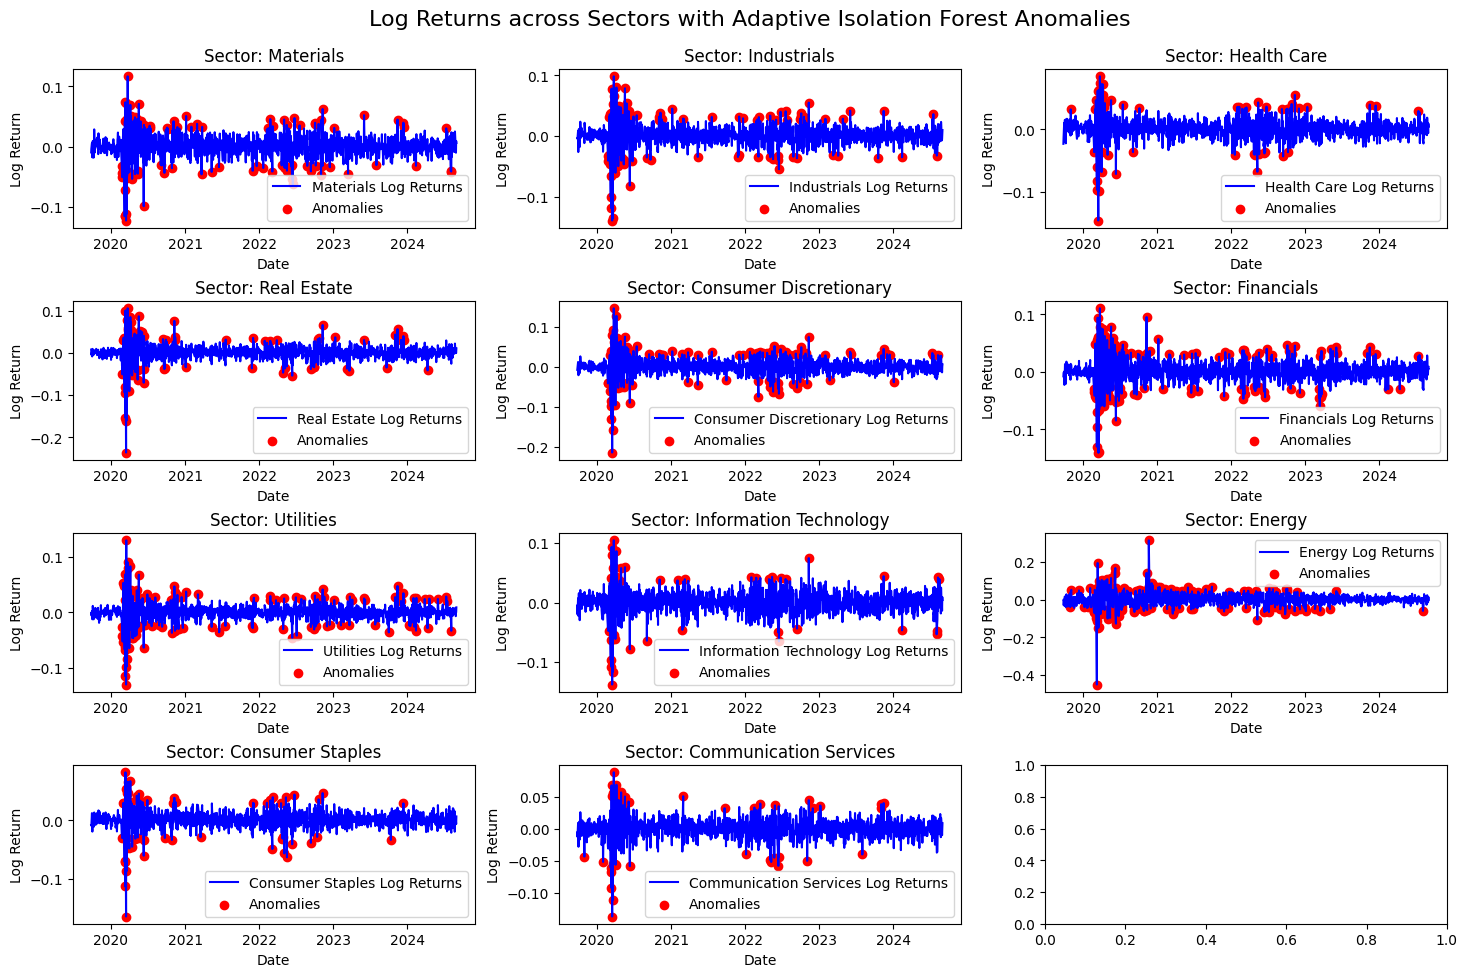

Final Parameters and Metrics for Each Sector:
                    Sector  n_estimators  max_samples  base_contamination  \
0                Materials            60          0.3                0.05   
1              Industrials            60          0.3                0.05   
2              Health Care            60          0.3                0.05   
3              Real Estate            60          0.3                0.05   
4   Consumer Discretionary            60          0.3                0.05   
5               Financials            60          0.3                0.05   
6                Utilities            60          0.3                0.05   
7   Information Technology            60          0.3                0.05   
8                   Energy            60          0.3                0.05   
9         Consumer Staples            60          0.3                0.05   
10  Communication Services            60          0.3                0.05   

    adaptive_contamination  s

In [3]:
data = pd.read_csv('mid_cap_all_sectors_ret.csv')
sectors = data.columns[1:]
dates = pd.to_datetime(data['date'])
data = data.drop(columns=['date'])

split_point = int(len(data) * 0.8)
train_df = data.iloc[:split_point]
test_df = data.iloc[split_point:].copy()

rolling_window = 20

# param_grid = {
#     'n_estimators': [85, 95, 100, 105, 115],
#     'max_samples': [0.4, 0.5, 0.6, 0.7],
#     'contamination': [0.03, 0.04, 0.045, 0.05, 0.055, 0.06]
# }

param_grid = {
    'n_estimators': [60],
    'max_samples': [0.3],
    'base_contamination': [0.05]
}
volatility_factor = 0.02

# rolling vol
def compute_rolling_vol(data, window_size=rolling_window):
    return data.rolling(window=window_size).std()

# dynamic contamination based on vol
def adaptive_contamination(volatility, base_contamination, volatility_factor):
    return min(0.1, base_contamination + volatility * volatility_factor)

metrics_summary = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns across Sectors with Adaptive Isolation Forest Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

for i, sector in enumerate(sectors):
    # Compute rolling volatility and mean volatility for this sector
    rolling_volatility = compute_rolling_vol(train_df[sector])
    mean_volatility = np.nanmean(rolling_volatility)

    best_silhouette = -1
    best_config = None
    best_model = None
    best_threshold = None
    best_test_anomalies = None

    for n_estimators in param_grid['n_estimators']:
        for max_samples in param_grid['max_samples']:
            for base_contamination in param_grid['base_contamination']:
                contamination = adaptive_contamination(mean_volatility, base_contamination, volatility_factor)

                model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples,
                                        contamination=contamination, random_state=42)

                # Train on sector data
                X_train = train_df[[sector]].values
                model.fit(X_train)

                # Calculate training scores and threshold
                train_scores = -model.decision_function(X_train)
                threshold = np.percentile(train_scores, 95)  # Set threshold at 95th percentile of training scores

                # Calculate silhouette score and MSE for the training data
                silhouette = silhouette_score(X_train, train_scores.reshape(-1, 1))
                mse = mean_squared_error(train_df[sector], model.decision_function(X_train))

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_config = {'n_estimators': n_estimators, 'max_samples': max_samples, 'base_contamination': base_contamination}
                    best_model = model
                    best_threshold = threshold

    # Apply best model on test data and calculate test scores
    X_test = test_df[[sector]].values
    test_scores = -best_model.decision_function(X_test)

    # Detect anomalies based on best threshold
    best_test_anomalies = (test_scores > best_threshold).astype(int)
    test_df[f'{sector}_anomaly'] = best_test_anomalies

    # Calculate anomaly percentage for this sector in test data
    anomaly_percentage = (sum(best_test_anomalies) / len(best_test_anomalies)) * 100

    metrics_summary.append({
        'Sector': sector,
        'n_estimators': best_config['n_estimators'],
        'max_samples': best_config['max_samples'],
        'base_contamination': best_config['base_contamination'],
        'adaptive_contamination': adaptive_contamination(mean_volatility, best_config['base_contamination'], volatility_factor),
        'silhouette_score': best_silhouette,
        'mse': mse,
        'anomaly_percentage': anomaly_percentage
    })
    row, col = i // 3, i % 3
    ax = axes[row, col]
    ax.plot(dates[split_point:], test_df[sector], label=f'{sector} Log Returns', color='blue')
    anomaly_dates = dates[split_point:][best_test_anomalies == 1]
    anomaly_values = test_df.loc[test_df[f'{sector}_anomaly'] == 1, sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_summary_df = pd.DataFrame(metrics_summary)
print("Final Parameters and Metrics for Each Sector:")
print(metrics_summary_df)
print("Anomaly Percentages by Sector in the Test Data:")
print(metrics_summary_df[['Sector', 'anomaly_percentage']])

In [4]:
anomaly_counts = test_df[[f'{sector}_anomaly' for sector in sectors]].sum()
anomaly_counts = pd.DataFrame({'Sector': sectors, 'Anomalies': anomaly_counts.values})

print("Count of Anomalies for Each Sector:")
print(anomaly_counts)

Count of Anomalies for Each Sector:
                    Sector  Anomalies
0                Materials         95
1              Industrials         91
2              Health Care         53
3              Real Estate         73
4   Consumer Discretionary        108
5               Financials        128
6                Utilities        116
7   Information Technology         42
8                   Energy        147
9         Consumer Staples         53
10  Communication Services         43


## **Delete**

**Log Return & Rolling Vol**

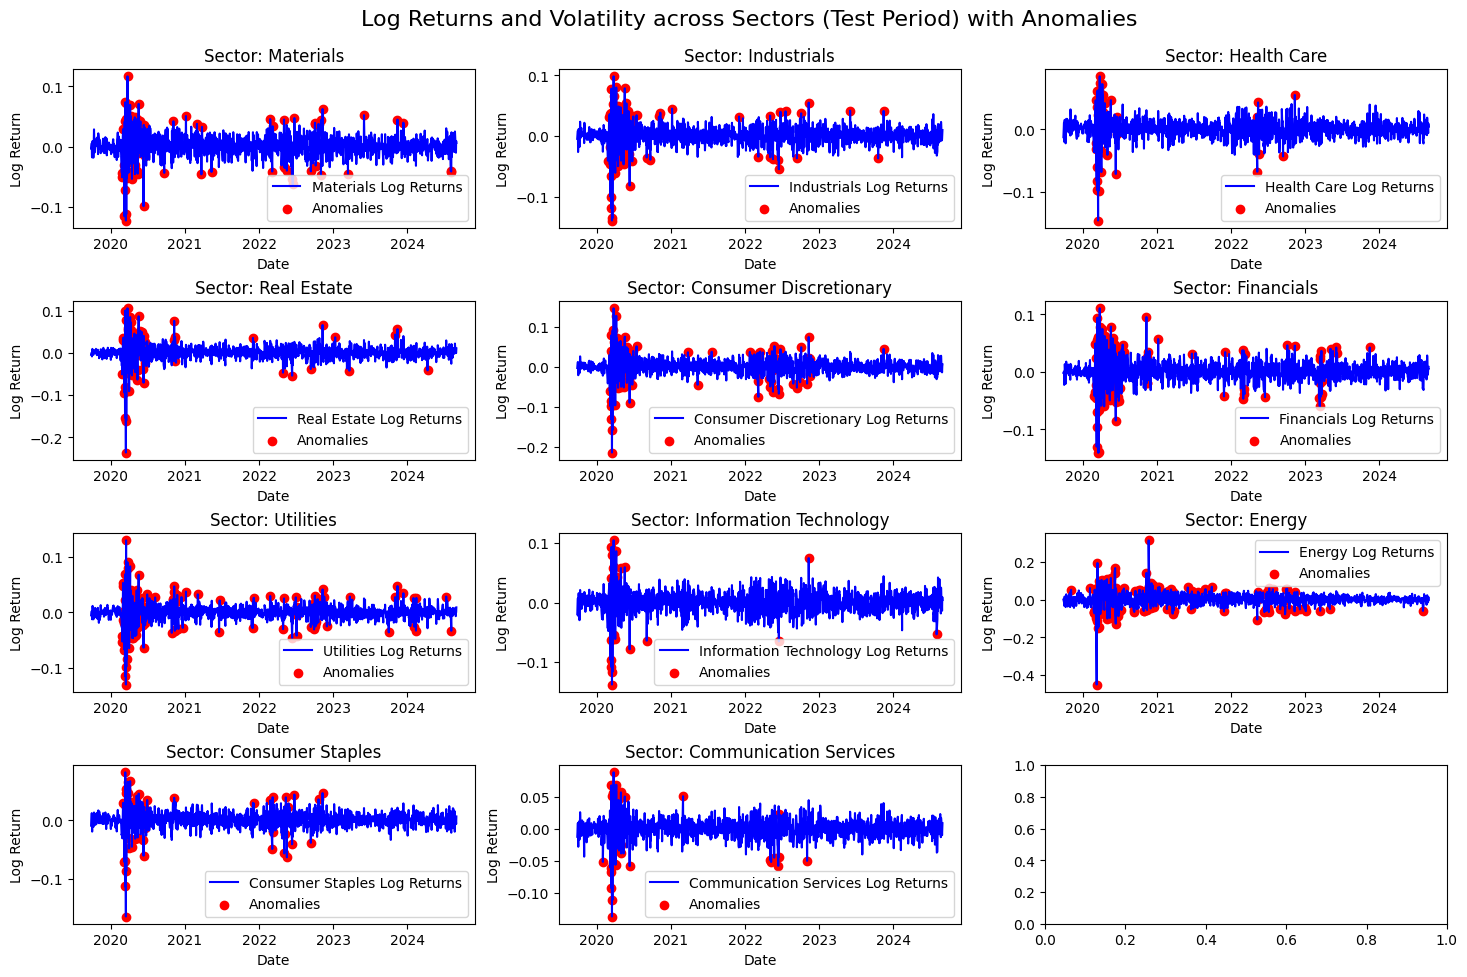

,silhouette_score,mse,anomaly_percentage
Materials,0.619371,0.024397,6.612903
Industrials,0.631485,0.025209,7.016129
Health Care,0.694686,0.025237,3.306452
Real Estate,0.717531,0.031645,5.000000
Consumer Discretionary,0.619575,0.025419,7.741935
Financials,0.620961,0.027915,8.467742
Utilities,0.624868,0.023449,9.596774
Information Technology,0.725573,0.027001,2.177419
Energy,0.559081,0.020216,11.935484
Consumer Staples,0.679176,0.024236,4.274194


In [ ]:
# 5-day rolling volatility for each sector as an additional feature
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns and Volatility across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with both log returns and volatility as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns and 5-day rolling volatility)
    X_train = train_df[[sector, f'{sector}_vol_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df

**Log Return & SMA & Rolling Vol**

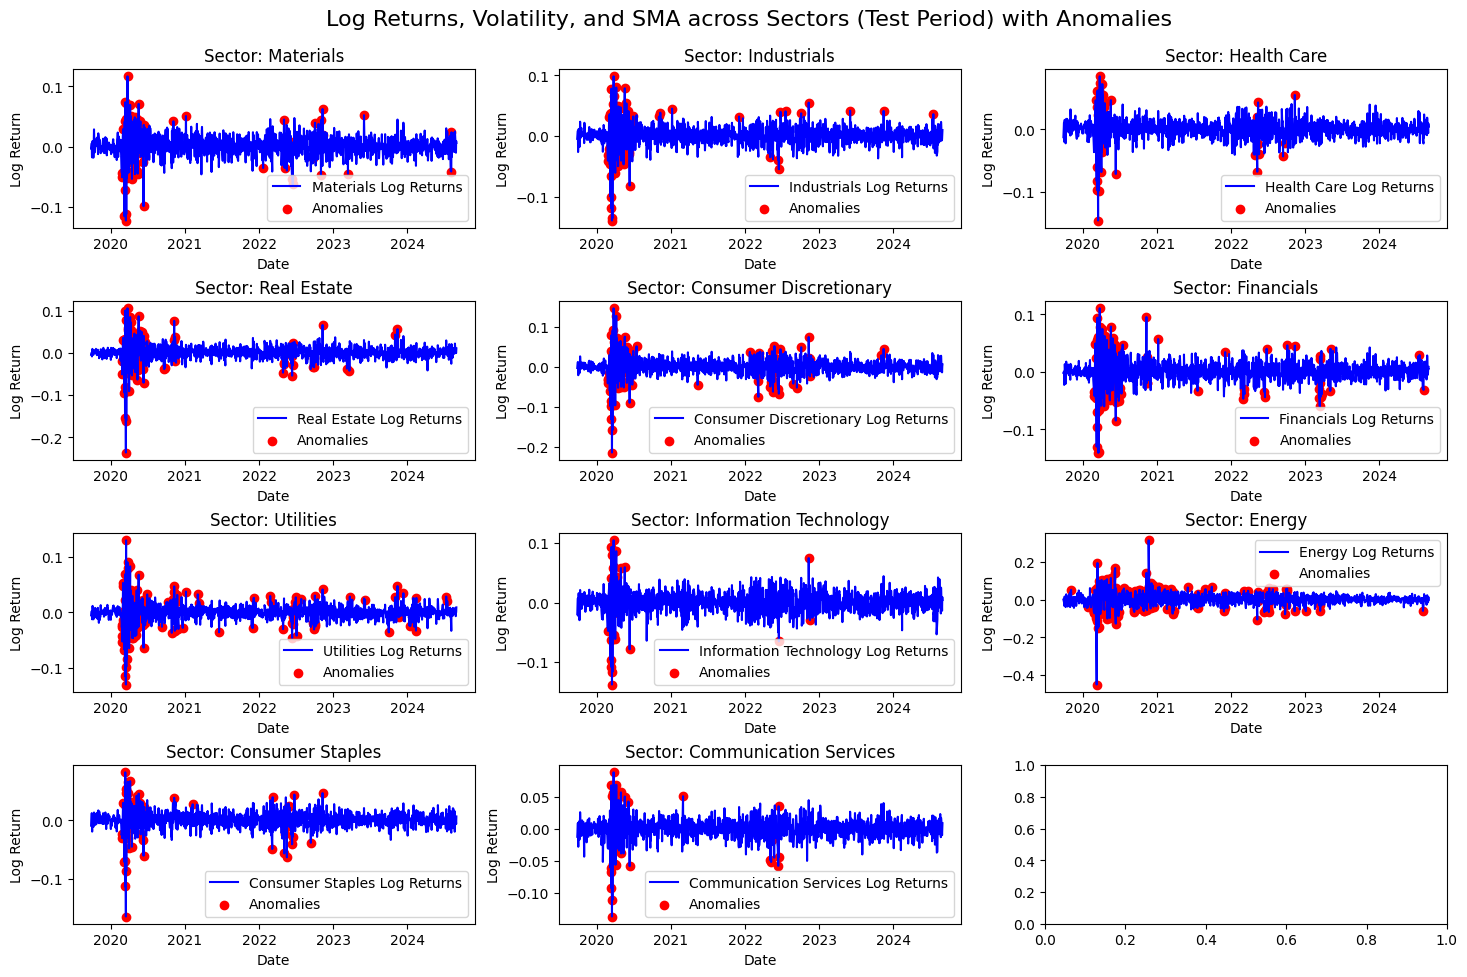

,silhouette_score,mse,anomaly_percentage
Materials,0.603130,0.025319,5.725806
Industrials,0.615562,0.024647,6.693548
Health Care,0.680138,0.026403,3.306452
Real Estate,0.668305,0.030400,6.290323
Consumer Discretionary,0.599461,0.024423,8.064516
Financials,0.606354,0.027655,8.145161
Utilities,0.598361,0.020094,9.596774
Information Technology,0.699175,0.029146,2.258065
Energy,0.518940,0.020889,13.145161
Consumer Staples,0.657630,0.025274,4.354839


In [ ]:
# 5-day rolling volatility and 5-day SMA for each sector as additional features
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()
    df[f'{sector}_sma_5'] = df[sector].rolling(window=5).mean()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns, Volatility, and SMA across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with log returns, volatility, and SMA as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns, 5-day rolling volatility, and 5-day SMA)
    X_train = train_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df